In [1]:
from helpers.helper_functions import read_and_set_df, pd, np, msno, go, plt, sns, px, tf

In [2]:
X_train = pd.read_csv('data/x_train_clean.csv', sep='$', decimal=".", engine='python') 
y_train = pd.read_csv('data/y_train_clean.csv', sep='$', decimal=".", engine='python')   
X_test = pd.read_csv('data/x_test_clean.csv', sep='$', decimal=".", engine='python') 
y_test = pd.read_csv('data/y_test_clean.csv', sep='$', decimal=".", engine='python') 

del X_train['Unnamed: 0']
del y_train['Unnamed: 0']
del X_test['Unnamed: 0']
del y_test['Unnamed: 0']
len(X_train), len(y_train), len(X_test), len(y_test)

(3346, 3346, 6040, 6040)

In [3]:
y_train['response'].unique()

array([0, 1], dtype=int64)

In [4]:
# Pakete für den Random Forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, make_scorer, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score      #, cumulative
import json

import kds

from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials , space_eval
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

## Random Forest Classifier Train Set

Default Values for Random Forest:

* `n_estimators`: 100
* `criterion`: 'gini'
* `max_depth`: None
* `main_samples_split`: 2
* `min_samples_leaf`: 1
* `min_weight_frachtion`: 0
* `max_features`: 'auto'

In [5]:
def get_auc_pr(y_train, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_train, y_proba)
    return auc(recall, precision)

# greater_is_better = höhere Werte sind besser - keine loss function 
scorer_auc_pr = make_scorer(get_auc_pr, greater_is_better = True, needs_proba=True)
scorer_acc = make_scorer(accuracy_score)

def hyperopt_train_test(params):
        clf = RandomForestClassifier(**params, n_jobs=-1)
        cv = cross_val_score(clf, X_train, y_train['response'], scoring=scorer_acc, cv=5, n_jobs=-1).mean()
        return cv

space = {'n_estimators': hp.choice('n_estimators', range(250, 1501, 250)),
         'max_depth': hp.choice('max_depth', range(1, 101, 10)),
         'max_features': hp.choice('max_features', (0.01, 0.05, 0.5, 'log2', 'sqrt', 'auto')),
         'min_samples_leaf': hp.choice('min_samples_leaf', (1, 3, 9, 15)),
         'min_samples_split': hp.choice('min_samples_split', range(1,151,1)),     #(0.5, 2, 3)
         #'max_leaf_nodes': hp.choice('max_leaf_nodes', range(2, 5)),
         'criterion': hp.choice('criterion', ["gini", "entropy"])
        }

best = 0
def fn(params):
    global best
    pr_auc = hyperopt_train_test(params)
    if pr_auc > best:
        best = pr_auc
    print(f'best: {best}\nparams: {params}')
    # We aim to maximize pr_auc, therefore we return it as a negative value
    return {'loss': -pr_auc, 'status': STATUS_OK}

trials = Trials()
# fmin = fine tuning the model and then print the best lost with its hyperparameters values
best = fmin(fn,
            space,
            algo=tpe.suggest,
            max_evals=20, 
            trials=trials)
            
print('best:', best)

best: 0.8646377975592887                              
params: {'criterion': 'entropy', 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 137, 'n_estimators': 1500}
best: 0.876303237177342                                                          
params: {'criterion': 'entropy', 'max_depth': 51, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 78, 'n_estimators': 1250}
best: 0.8810927425652009                                                         
params: {'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 9, 'min_samples_split': 32, 'n_estimators': 1250}
best: 0.8810927425652009                                                         
params: {'criterion': 'entropy', 'max_depth': 61, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 91, 'n_estimators': 250}
best: 0.8810927425652009                                                         
params: {'criterion': 'gini', 'max_depth': 

In [6]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
# Show best model
params_random_forest_opt = space_eval(space, best)
params_random_forest_opt

{'criterion': 'gini',
 'max_depth': 31,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 49,
 'n_estimators': 1250}

In [7]:
# training final classifier
clf = RandomForestClassifier(**params_random_forest_opt, n_jobs=-1)

fit_rf = clf.fit(X_train, y_train['response'])
y_pred_proba = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

print(y_pred)
print(y_pred_proba)

[0 0 0 ... 1 1 1]
[1.90939998e-03 1.18497718e-04 5.35467700e-03 ... 7.19161150e-01
 9.09528310e-01 6.35340854e-01]


In [8]:
# Funktion für den pr_auc schreiben
def get_auc_pr(y_test, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    return auc(recall, precision)

# pr_auc ausgeben lassen
pr_auc_rf = get_auc_pr(y_test[['response']], y_pred)
print(pr_auc_rf)

0.8950889385635663


# Evaluation 

#### Entscheidung für ein Gütemaß

Accuracy:  Die Accuracy wird anhand der vorhergesagten Klassen berechnet. Das bedeutet, dass sie auch den verwendeten Threshold beinhaltet, der zunächst noch optimiert werden muss. 

ROC-AUC und PR-AUC:
Der roc_auc und der pr_auc betrachten beide die Vorhersagewerte von Klassifizierungsmodellen und nicht die Klassenzuordnungen mit Schwellwerten. Der Unterschied besteht jedoch darin, dass roc_auc den Anteil der wahren Positiven (TPR) und den Anteil der falschen Positiven (FPR) berücksichtigt, während der pr_auc den positiven Vorhersagewert (PPV) und den Anteil der wahren Positiven (TPR) berücksichtigt. Da wir in unserem Fall mehr Fokus auf die positive Klasse legen, ist die Verwendung des pr_auc, der empfindlicher auf Verbesserungen für die positive Klasse reagiert, die bessere Wahl.

Darum werden wir als maßgebliches Gütemaß den pr_auc in diesem Anwendungsfall verwenden.

#### Visuelle Darstellung der Confusion Matrix

<AxesSubplot:>

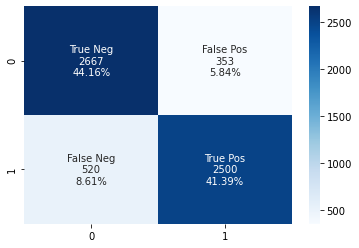

In [9]:
# Konfusionsmatrix
cf_matrix = confusion_matrix(y_test[['response']], y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]


labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#### Feature Importance 

In [10]:
# Feature Importance für den Trainingsdatensatz plotten

#Feature Importance in einem Data Frame ablegen und absteigend nach den höchsten Werten sortieren 
feature_importances=pd.DataFrame({'features':X_train.columns,'feature_importance':fit_rf.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

# Bar Chart erstellen 
fig = go.Figure(go.Bar(
            x=feature_importances['feature_importance'].sort_values(ascending=True),
            y=X_train.columns,
            text=round(feature_importances['feature_importance'].sort_values(ascending=True), 4),
            marker_color= 'rgb(18,116,117)',
            orientation='h'))

fig.update_traces(textposition='outside')
fig.update_layout(title_text = 'Feature Importance')
fig.show()

#### ROC Kurve

In [11]:
fpr, tpr, _ = roc_curve(y_test['response'], y_pred_proba)
auc_score = roc_auc_score(y_test['response'], y_pred_proba)


fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC-Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)


fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)


fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

#### Precision-Recall-Curve

Der `Recall` sagt also etwas darüber aus, wieviele der in der Datenbank vorhandenen relevanten Dokumente gefunden wurden – ins Verhältnis gesetzt zur Anzahl aller relevanten Dokumente in der Datenbank. 

Die `Precision` setzt jene Zahl ins Verhältnis zur Zahl der insgesamt gefundenen Dokumente, sie gibt an, wieviele der gefundenen relevant sind. Grob gesprochen: Recall – wieviel habe ich gefunden, wieviel Substanz hat die Datenbank ; Precision – wieviel Unbrauchbares habe ich gefunden, wie genau kann man in der Datenbank suchen?

In [12]:
# Muss noch angepasst werden 
tpr, fpr, thresholds = roc_curve(y_test['response'], y_pred_proba)
precision_recall_threshold = pd.DataFrame(precision_recall_curve(y_test[['response']], y_pred_proba)).transpose()
precision_recall_threshold.columns = ['Precision', 'Recall', 'Threshold']

fig = px.area(
    x=precision_recall_threshold['Recall'], y=precision_recall_threshold['Precision'],
    title=f'Precision-Recall Curve (AUC={pr_auc_rf:.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

#### Precision-Recall-Threshold Curve

In [13]:
# Data Frame erzeugen, der die precision, recall, threshold werte enthält 
precision_recall_threshold = np.transpose(pd.DataFrame(precision_recall_curve(y_test[['response']], y_pred_proba)))
precision_recall_threshold.columns = ['Precision', 'Recall', 'Threshold']

# Schnittpunkt von Precision und Threshold berechnen und den dazugehörigen Threshold in einem Data Frame ablegen 
precision_recall_threshold['distance']  =  abs(precision_recall_threshold['Precision'] - precision_recall_threshold['Recall'])
intersection_precision_recall_threshold = precision_recall_threshold.loc[precision_recall_threshold['distance'] == precision_recall_threshold['distance'].min()]
intersection = intersection_precision_recall_threshold['Threshold']


# Plot erzeugen 
fig = go.Figure()

# Trace für die Precison und die dazugehörigen Thresholds
fig.add_trace(go.Scatter(x=precision_recall_threshold['Threshold'], y=precision_recall_threshold['Precision'],
                    fill='tozeroy', fillcolor='rgba(248, 118, 109, 0.5)', opacity=0.5,
                    hoveron = 'points+fills', # select where hover is active
                    line_color='rgba(248, 118, 109, 0.5)',
                    name= 'Precision',
                    hoverinfo = 'text+x+y'))


# Trace für den Recall und die dazugehörigen Thresholds
fig.add_trace(go.Scatter(x=precision_recall_threshold['Threshold'], y=precision_recall_threshold['Recall'],
                    fill='tozeroy', fillcolor = 'rgba(0, 191, 196, 0.5)',
                    hoveron='points',
                    line_color='rgba(0, 191, 196, 0.5)',
                    name= 'Recall',
                    hoverinfo='text+x+y')) 


# Schnittpunkt von Precision und Recall einfügen
fig.add_traces(go.Scatter(
    x= [intersection.values[0],intersection.values[0]],
    y=[0,1],
    mode='lines',
    name=f'threshold {intersection.values[0]:.4f}',
    line={'dash': 'dash', 
          'color': 'silver',
          'width': 2}
    ))


# Layout anpoassen
fig.update_layout(title = f'Precision-Recall-Threshold Curve (AUC={pr_auc_rf:.4f})')
fig.update_layout(hovermode='x unified')
fig.update_xaxes(title_text='Threshold')
fig.update_yaxes(title_text='Precision / Recall')

fig.show()

#### Sensitivity-Specificity-Threshold Curve

In [14]:
fpr, tpr, thresholds =roc_curve(y_test[['response']], y_pred_proba)
sensitivity_specificity_threshold = pd.DataFrame({'Sensitivity' : tpr,'Specificitiy' : 1 - fpr, 'Threshold': thresholds})

# Es war ein Threshold mit dem Wert von 1,7 drin - Den habe ich gelöscht, da der plot sonst extrem verzerrt wird
sensitivity_specificity_threshold = sensitivity_specificity_threshold.iloc[1: , :]

# Schnittpunkt von Precision und Threshold berechnen und den dazugehörigen Threshold in einem Data Frame ablegen 
sensitivity_specificity_threshold['distance']  =  abs(sensitivity_specificity_threshold['Sensitivity'] - sensitivity_specificity_threshold['Specificitiy'])
intersection_specificity_threshold = sensitivity_specificity_threshold.loc[sensitivity_specificity_threshold['distance'] == sensitivity_specificity_threshold['distance'].min()]
intersection_spt = intersection_specificity_threshold['Threshold']


# Plot erzeugen 
fig = go.Figure()

# Trace für die Precison und die dazugehörigen Thresholds
fig.add_trace(go.Scatter(x=sensitivity_specificity_threshold['Threshold'], y=sensitivity_specificity_threshold['Sensitivity'],
                    fill='tozeroy', fillcolor='rgba(248, 118, 109, 0.5)', opacity=0.5,
                    hoveron = 'points+fills', # select where hover is active
                    line_color='rgba(248, 118, 109, 0.5)',
                    name= 'Sensitivity',
                    hoverinfo = 'text+x+y'))


# Trace für den Recall und die dazugehörigen Thresholds
fig.add_trace(go.Scatter(x=sensitivity_specificity_threshold['Threshold'], y=sensitivity_specificity_threshold['Specificitiy'],
                    fill='tozeroy', fillcolor = 'rgba(0, 191, 196, 0.5)',
                    hoveron='points',
                    line_color='rgba(0, 191, 196, 0.5)',
                    name= 'Specificitiy',
                    hoverinfo='text+x+y')) 


# Schnittpunkt von Precision und Recall einfügen
fig.add_traces(go.Scatter(
    x= [intersection_spt.values[0],intersection_spt.values[0]],
    y=[0,1],
    mode='lines',
    name=f'threshold {intersection_spt.values[0]:.4f}',
    line={'dash': 'dash', 
          'color': 'silver',
          'width': 2}
    ))


# Layout anpoassen
fig.update_layout(title = 'Sensitivity-Specificity-Threshold Curve')
fig.update_layout(hovermode='x unified')
fig.update_xaxes(title_text='Threshold')
fig.update_yaxes(title_text='Sensitivity / Specificity')

fig.show()

#### Cumulative Gain Chart

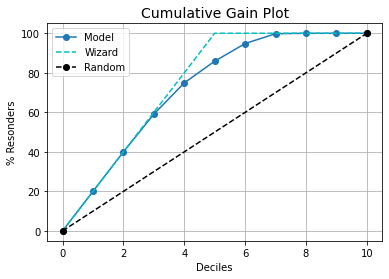

In [15]:
kds.metrics.plot_cumulative_gain(np.array(y_test['response']), y_pred_proba)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.971,1.000,0.987,604.0,604.0,0.0,302.0,604,100.000,604.0,604.0,604,0.0,10.0,20.000,20.0,0.000,20.000,2.000
1,2,0.899,0.971,0.940,604.0,603.0,1.0,302.0,604,99.834,1208.0,1207.0,1208,1.0,20.0,39.967,40.0,0.033,39.934,1.998
2,3,0.790,0.899,0.847,604.0,577.0,27.0,302.0,604,95.530,1812.0,1784.0,1812,28.0,30.0,59.073,60.0,0.927,58.146,1.969
3,4,0.602,0.789,0.695,604.0,478.0,126.0,302.0,604,79.139,2416.0,2262.0,2416,154.0,40.0,74.901,80.0,5.099,69.802,1.873
4,5,0.467,0.602,0.531,604.0,331.0,273.0,302.0,604,54.801,3020.0,2593.0,3020,427.0,50.0,85.861,100.0,14.139,71.722,1.717
5,6,0.336,0.467,0.405,604.0,270.0,334.0,302.0,0,44.702,3624.0,2863.0,3020,761.0,60.0,94.801,100.0,25.199,69.602,1.580
6,7,0.118,0.336,0.241,604.0,150.0,454.0,302.0,0,24.834,4228.0,3013.0,3020,1215.0,70.0,99.768,100.0,40.232,59.536,1.425
7,8,0.004,0.117,0.041,604.0,6.0,598.0,302.0,0,0.993,4832.0,3019.0,3020,1813.0,80.0,99.967,100.0,60.033,39.934,1.250
8,9,0.001,0.004,0.002,604.0,0.0,604.0,302.0,0,0.000,5436.0,3019.0,3020,2417.0,90.0,99.967,100.0,80.033,19.934,1.111
9,10,0.000,0.001,0.000,604.0,1.0,603.0,302.0,0,0.166,6040.0,3020.0,3020,3020.0,100.0,100.000,100.0,100.000,0.000,1.000


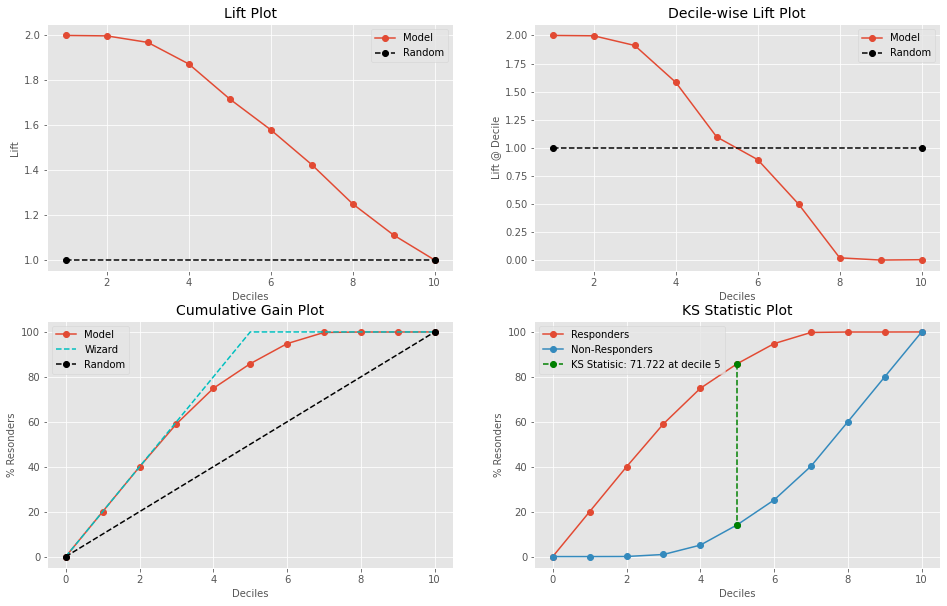

In [16]:
kds.metrics.report(np.array(y_test['response']), y_pred_proba,plot_style='ggplot')

Lift Curve Plot

In [17]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=list(range(10,100+10,10)), y=np.repeat(1,10),
#                     mode='lines+markers',
#                     name='lines+markers'))
# fig.add_trace(go.Scatter(x=list(range(10,100+10,10)), y=lift.Lift,
#                     mode='lines+markers',
#                     name='lines+markers'))

# fig.update_xaxes(
#         title_text = "% of Data Set",
# )

# fig.update_yaxes(
#         title_text = "Lift",
#         )
# fig.update_layout(title='Lift Charts',)

# fig.show()

Gain Chart

In [18]:
# gain = lift.Gain.tolist()
# gain.insert(0,0)
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=list(range(0,100+10,10)), y=list(range(0,100+10,10)),
#                     mode='lines+markers',
#                     name='lines+markers'))
# fig.add_trace(go.Scatter(x=list(range(0,100+10,10)), y=gain,
#                     mode='lines+markers',
#                     name='lines+markers'))

# fig.update_xaxes(
#         title_text = "% of Data Set",
# )

# fig.update_yaxes(
#         title_text = "% of Gain",
#         )
# fig.update_layout(title='Gain Charts',)

# fig.show()

#### Modell vergleiche anhand eines Gütemaßes in einer Tabelle 

In [19]:
# Modell Evaluation
# Hier können wir dann alle Modell anhand von verschiedenen Gütemaßen in einer Tabelle vergleichen 
models = pd.DataFrame({
    'Model': ['Random Forest'],
    'Score': [pr_auc_rf]
})

# Die cmpa wird erst bei mehreren Zeilen richtig angezeigt
models.sort_values(by='Score', ascending=False).style.background_gradient(cmap='Greens',subset = ['Score'])   

,Model,Score
0,Random Forest,0.895089


# Gradiant Boosting Tree

In [20]:
def hyperopt_boostedtree_train_test(params):
        clb = GradientBoostingClassifier(**params)
        cv = cross_val_score(clb, X_train, y_train['response'], scoring=scorer_acc, cv=5, n_jobs=-1).mean()
        return cv
    
space_bt = {'loss': hp.choice('loss', ['deviance', 'exponential']),
            'learning_rate': hp.choice('learing_rate', (0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2)),
            'min_samples_split': hp.choice('min_samples_split', (0.1, 0.5, 12)),
            'min_samples_leaf': hp.choice('min_samples_leaf', (0.1, 0.5, 12)),
            'n_estimators': hp.choice('n_estimators', range(1, 20)),
            'max_depth': hp.choice('max_depth', range(1, 10, 2)),
            'max_features': hp.choice('max_features', ('log2', 'sqrt', 'auto')),
            'criterion': hp.choice('criterion', ('friedman_mse', 'squared_error')),
            'subsample': hp.choice('subsample', (0.5, 0.685, 0.85, 0.9, 0.951)),
            'n_estimators': hp.choice('n_estimators', range(100, 1501, 250))
            }

best_bt = 0

def fn(params):
    global best_bt
    pr_auc = hyperopt_boostedtree_train_test(params)
    if pr_auc > best_bt:
        best_bt = pr_auc
    print('new best:', best_bt, params)
    # We aim to maximize pr_auc, therefore we return it as a negativve value
    return {'loss': -pr_auc, 'status': STATUS_OK}

trials = Trials()
# fmin = fine tuning the model and then print the best lost with its hyperparameters values
best_bt = fmin(fn,
            space_bt,
            algo=tpe.suggest,
            max_evals=20, trials=trials)
            
print('best_bt:', best_bt)

new best:                                             
0                                                     
{'criterion': 'squared_error', 'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 0.5, 'min_samples_split': 12, 'n_estimators': 850, 'subsample': 0.9}
new best:                                             
0.49970104633781764                                           
{'criterion': 'friedman_mse', 'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 0.5, 'min_samples_split': 0.1, 'n_estimators': 850, 'subsample': 0.685}
new best:                                                                         
0.8341458626151754                                                                
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'n_estimators': 100, 'subsample':

In [21]:
# Show best model
params_boosted_tree_opt = space_eval(space_bt, best_bt)
params_boosted_tree_opt

{'criterion': 'friedman_mse',
 'learning_rate': 0.025,
 'loss': 'deviance',
 'max_depth': 9,
 'max_features': 'log2',
 'min_samples_leaf': 12,
 'min_samples_split': 12,
 'n_estimators': 600,
 'subsample': 0.9}

In [22]:
rand_for = RandomForestClassifier(n_jobs=-1, random_state=41)

rand_for.fit(X_train, y_train)

res = rand_for.predict(X_test)
resa = rand_for.predict_proba(X_test)[:,1]

confusion_matrix(y_test, res)
fpr, tpr, _ = roc_curve(y_test['response'], resa)
auc_score = roc_auc_score(y_test['response'], resa)


fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC-Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)


fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)


fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

<ipython-input-22-108594927d2c>:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [23]:
# training final classifier
gb = GradientBoostingClassifier(**params_boosted_tree_opt)

fit_bt = gb.fit(X_train, y_train['response'])
y_pred_proba_bt = fit_bt.predict_proba(X_test)[:,1]
y_pred_bt = fit_bt.predict(X_test)

print(y_pred_bt)
print(y_pred_proba_bt)

# training final classifier
clf = RandomForestClassifier(**params_random_forest_opt, n_jobs=-1)

fit_rf = clf.fit(X_train, y_train['response'])
y_pred_proba = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

print(y_pred)
print(y_pred_proba)

[0 0 0 ... 1 1 1]
[8.32001681e-04 1.45750156e-04 6.39406581e-04 ... 7.95619525e-01
 9.93123142e-01 6.44766085e-01]
[0 0 0 ... 1 1 1]
[0.00396292 0.         0.00575362 ... 0.73583017 0.91676331 0.63190678]


#### Evaluation Boosted Tree

<AxesSubplot:>

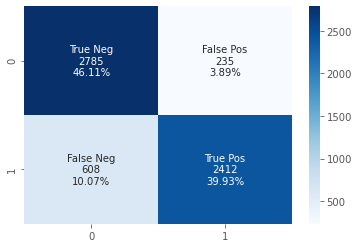

In [24]:
# Konfusionsmatrix
cf_matrix_bt = confusion_matrix(y_test[['response']], y_pred_bt)

group_names_bt = ['True Neg','False Pos','False Neg','True Pos']

group_counts_bt = ["{0:0.0f}".format(value) for value in
                cf_matrix_bt.flatten()]

group_percentages_bt = ["{0:.2%}".format(value) for value in cf_matrix_bt.flatten()/np.sum(cf_matrix_bt)]


labels_bt = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_bt,group_counts_bt,group_percentages_bt)]

labels_bt = np.asarray(labels_bt).reshape(2,2)

sns.heatmap(cf_matrix_bt, annot=labels_bt, fmt='', cmap='Blues')

In [25]:
# Feature Importance für den Trainingsdatensatz plotten
#Feature Importance in einem Data Frame ablegen und absteigend nach den höchsten Werten sortieren 
feature_importances=pd.DataFrame({'features':X_train.columns,'feature_importance':fit_bt.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

# Bar Chart erstellen 
fig = go.Figure(go.Bar(
            x=feature_importances['feature_importance'].sort_values(ascending=True),
            y=X_train.columns,
            text=round(feature_importances['feature_importance'].sort_values(ascending=True), 4),
            marker_color= 'rgb(18,116,117)',
            orientation='h'))

fig.update_traces(textposition='outside')
fig.update_layout(title_text = 'Feature Importance')
fig.show()

#### ROC-Curve

In [26]:
fpr, tpr, _ = roc_curve(y_test['response'], y_pred_proba_bt)
auc_score_bt = roc_auc_score(y_test['response'], y_pred_proba_bt)


fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC-Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)


fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)


fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

#### Precision-Recall Curve

In [27]:
# Muss noch angepasst werden 
tpr, fpr, thresholds = roc_curve(y_test['response'], y_pred_proba_bt)
# pr_auc ausgeben lassen
pr_auc_bt = get_auc_pr(y_test[['response']], y_pred_bt)
precision_recall_threshold_bt = pd.DataFrame(precision_recall_curve(y_test[['response']], y_pred_proba_bt)).transpose()
precision_recall_threshold_bt.columns = ['Precision', 'Recall', 'Threshold']

fig = px.area(
    x=precision_recall_threshold_bt['Recall'], y=precision_recall_threshold_bt['Precision'],
    title=f'Precision-Recall Curve (AUC={pr_auc_bt:.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

#### Precision-Recall-Threshold Curve

In [28]:
# Data Frame erzeugen, der die precision, recall, threshold werte enthält 
precision_recall_threshold_bt = np.transpose(pd.DataFrame(precision_recall_curve(y_test[['response']], y_pred_proba_bt)))
precision_recall_threshold_bt.columns = ['Precision', 'Recall', 'Threshold']

# Schnittpunkt von Precision und Threshold berechnen und den dazugehörigen Threshold in einem Data Frame ablegen 
precision_recall_threshold_bt['distance']  =  abs(precision_recall_threshold_bt['Precision'] - precision_recall_threshold_bt['Recall'])
intersection_precision_recall_threshold_bt = precision_recall_threshold_bt.loc[precision_recall_threshold_bt['distance'] == precision_recall_threshold_bt['distance'].min()]
intersection_bt = intersection_precision_recall_threshold_bt['Threshold']


# Plot erzeugen 
fig = go.Figure()

# Trace für die Precison und die dazugehörigen Thresholds
fig.add_trace(go.Scatter(x=precision_recall_threshold_bt['Threshold'], y=precision_recall_threshold_bt['Precision'],
                    fill='tozeroy', fillcolor='rgba(248, 118, 109, 0.5)', opacity=0.5,
                    hoveron = 'points+fills', # select where hover is active
                    line_color='rgba(248, 118, 109, 0.5)',
                    name= 'Precision',
                    hoverinfo = 'text+x+y'))


# Trace für den Recall und die dazugehörigen Thresholds
fig.add_trace(go.Scatter(x=precision_recall_threshold_bt['Threshold'], y=precision_recall_threshold_bt['Recall'],
                    fill='tozeroy', fillcolor = 'rgba(0, 191, 196, 0.5)',
                    hoveron='points',
                    line_color='rgba(0, 191, 196, 0.5)',
                    name= 'Recall',
                    hoverinfo='text+x+y')) 


# Schnittpunkt von Precision und Recall einfügen
fig.add_traces(go.Scatter(
    x= [intersection_bt.values[0],intersection_bt.values[0]],
    y=[0,1],
    mode='lines',
    name=f'threshold {intersection_bt.values[0]:.4f}',
    line={'dash': 'dash', 
          'color': 'silver',
          'width': 2}
    ))


# Layout anpoassen
fig.update_layout(title = f'Precision-Recall-Threshold Curve (pr_AUC={pr_auc_bt:.4f})')
fig.update_layout(hovermode='x unified')
fig.update_xaxes(title_text='Threshold')
fig.update_yaxes(title_text='Precision / Recall')

fig.show()

#### Sensitivity-Specificity-Threshold Curve

In [29]:
fpr, tpr, thresholds =roc_curve(y_test[['response']], y_pred_proba_bt)
sensitivity_specificity_threshold_bt = pd.DataFrame({'Sensitivity' : tpr,'Specificity' : 1 - fpr, 'Threshold': thresholds})

# Es war ein Threshold mit dem Wert von 1,7 drin - Den habe ich gelöscht, da der plot sonst extrem verzerrt wird
sensitivity_specificity_threshold_bt = sensitivity_specificity_threshold_bt.iloc[1: , :]

# Schnittpunkt von Precision und Threshold berechnen und den dazugehörigen Threshold in einem Data Frame ablegen 
sensitivity_specificity_threshold_bt['distance']  =  abs(sensitivity_specificity_threshold_bt['Sensitivity'] - sensitivity_specificity_threshold_bt['Specificity'])
intersection_specificity_threshold = sensitivity_specificity_threshold_bt.loc[sensitivity_specificity_threshold_bt['distance'] == sensitivity_specificity_threshold_bt['distance'].min()]
intersection_spt_bt = intersection_specificity_threshold['Threshold']


# Plot erzeugen 
fig = go.Figure()

# Trace für die Precison und die dazugehörigen Thresholds
fig.add_trace(go.Scatter(x=sensitivity_specificity_threshold_bt['Threshold'], y=sensitivity_specificity_threshold_bt['Sensitivity'],
                    fill='tozeroy', fillcolor='rgba(248, 118, 109, 0.5)', opacity=0.5,
                    hoveron = 'points+fills', # select where hover is active
                    line_color='rgba(248, 118, 109, 0.5)',
                    name= 'Sensitivity',
                    hoverinfo = 'text+x+y'))


# Trace für den Recall und die dazugehörigen Thresholds
fig.add_trace(go.Scatter(x=sensitivity_specificity_threshold_bt['Threshold'], y=sensitivity_specificity_threshold_bt['Specificity'],
                    fill='tozeroy', fillcolor = 'rgba(0, 191, 196, 0.5)',
                    hoveron='points',
                    line_color='rgba(0, 191, 196, 0.5)',
                    name= 'Specificity',
                    hoverinfo='text+x+y')) 


# Schnittpunkt von Precision und Recall einfügen
fig.add_traces(go.Scatter(
    x= [intersection_spt_bt.values[0],intersection_spt_bt.values[0]],
    y=[0,1],
    mode='lines',
    name=f'threshold {intersection_spt_bt.values[0]:.4f}',
    line={'dash': 'dash', 
          'color': 'silver',
          'width': 2}
    ))


# Layout anpoassen
fig.update_layout(title = 'Sensitivity-Specificity-Threshold Curve')
fig.update_layout(hovermode='x unified')
fig.update_xaxes(title_text='Threshold')
fig.update_yaxes(title_text='Sensitivity / Specificity')

fig.show()

# Neuronal Network 

In [30]:
import tensorflow 
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')

In [31]:
# Make scorer accuracy
score_acc = make_scorer(accuracy_score)

The following code creates the objective function containing the Neural Network model. The function will return returns the score of the cross-validation.

In [32]:
# Create function
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)

    def nn_cl_fun():
        opt = Adam(lr = learning_rate)
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=10, activation=activation))
        nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return nn
        
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train['response'], scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

The code below sets the range of hyperparameters and run the Bayesian Optimization

In [33]:
# Set paramaters
params_nn ={
    'neurons': (5, 10),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(20, 50),
    'epochs':(10, 50)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  epochs   | learni... |  neurons  | optimizer |
-------------------------------------------------------------------------------------------------
|  1        |  0.5006   |  5.51     |  25.07    |  27.44    |  0.7716   |  6.477    |  1.044    |
|  2        |  0.5006   |  0.2023   |  32.61    |  19.55    |  0.3443   |  9.954    |  1.664    |
|  3        |  0.5      |  0.7307   |  40.09    |  34.85    |  0.2815   |  7.331    |  0.8286   |
|  4        |  0.5003   |  0.6656   |  47.02    |  41.76    |  0.8422   |  9.076    |  6.937    |
|  5        |  0.5      |  5.195    |  44.41    |  26.85    |  0.03717  |  7.271    |  0.7373   |
|  6        |  0.5      |  7.355    |  40.93    |  32.61    |  0.2815   |  9.992    |  0.9663   |
|  7        |  0.4994   |  5.539    |  34.55    |  26.2     |  0.7306   |  6.614    |  2.804    |
|  8        |  0.5006   |  2.871    |  48.42    |  46.75    |  0.8157   |  5.17     |  6.604    |
|  9        |  0.499

Die besten hyperparameter ausgeben lassen 

In [34]:
params_nn_ = nn_bo.max['params']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_

{'activation': <keras.layers.advanced_activations.LeakyReLU at 0x19ee3dad9a0>,
 'batch_size': 34.49505150188073,
 'epochs': 12.482634526489132,
 'learning_rate': 0.5022805646848322,
 'neurons': 6.636655809510143,
 'optimizer': 2.888375035375601}

Erstellen einer Funktion zum Tunen des Modells

In [35]:
# Create function
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=10, activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization())
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

Im Folgenden wird nun nach den optimalen Hyperparametern und Layern gesucht 

In [36]:
params_nn2 ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.5236   |  5.51     |  335.3    |  0.4361   |  0.2308   |  43.63    |  1.298    |  1.045    |  0.426    |  31.48    |  0.3377   |  6.935    |
|  2        |  0.4973   |  2.14     |  265.0    |  0.6696   |  0.1864   |  41.94    |  1.932    |  1.237    |  0.08322  |  91.07    |  0.794    |  5.884    |
|  3        |  0.5      |  7.337    |  992.8    |  0.5773   |  0.2441   |  53.71    |  1.055    |  1.908    |  0.1143   |  83.55    |  0.6977   |  3.957    |
|  4        |  0.4994   |  2.468    |  998.8    |  0.138    |  0.1846   |  58.8     |  1.81     |  2.456    |  0.3296   |  46.05    |  0.319    |  6.631    |
|  5        |  0.5      |  8.268    |  851.1    |  0

Die besten Hyperparamter und Layer ausgeben lassen

In [37]:
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

{'activation': 'relu',
 'batch_size': 242,
 'dropout': 0.1279608146375314,
 'dropout_rate': 0.010014947837176436,
 'epochs': 38,
 'layers1': 2,
 'layers2': 1,
 'learning_rate': 0.18755133602737314,
 'neurons': 23,
 'normalization': 0.6830131255680931,
 'optimizer': <keras.optimizer_v2.adadelta.Adadelta at 0x19ef398c280>}

Fit the final Model

In [38]:
# Fitting Neural Network
def nn_cl_fun():
    nn = Sequential()
    nn.add(Dense(params_nn_['neurons'], input_dim=10, activation=params_nn_['activation']))
    if params_nn_['normalization'] > 0.5:
        nn.add(BatchNormalization())
    for i in range(params_nn_['layers1']):
        nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    if params_nn_['dropout'] > 0.5:
        nn.add(Dropout(params_nn_['dropout_rate'], seed=123))
    for i in range(params_nn_['layers2']):
        nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(loss='binary_crossentropy', optimizer=params_nn_['optimizer'], metrics=['accuracy'])
    return nn
        
es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=nn_cl_fun, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'],
                         verbose=0)
 
nn_final_model = nn.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=1)


Epoch 1/38
14/14 [==============================] - 1s 18ms/step - loss: 0.7262 - accuracy: 0.5332 - val_loss: 1.5917 - val_accuracy: 0.5013
Epoch 2/38
14/14 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5738 - val_loss: 1.0080 - val_accuracy: 0.5031
Epoch 3/38
14/14 [==============================] - 0s 5ms/step - loss: 0.6835 - accuracy: 0.5974 - val_loss: 0.8244 - val_accuracy: 0.5051
Epoch 4/38
14/14 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.5965 - val_loss: 0.7569 - val_accuracy: 0.5237
Epoch 5/38
14/14 [==============================] - 0s 5ms/step - loss: 0.6745 - accuracy: 0.6121 - val_loss: 0.7338 - val_accuracy: 0.5156
Epoch 6/38
14/14 [==============================] - 0s 4ms/step - loss: 0.6724 - accuracy: 0.6157 - val_loss: 0.7091 - val_accuracy: 0.5368
Epoch 7/38
14/14 [==============================] - 0s 4ms/step - loss: 0.6702 - accuracy: 0.6204 - val_loss: 0.6953 - val_accuracy: 0.5694
Epoch 8/38
14/14 [=

Evaluation des Modells auf dem Testdatensatz

In [39]:
y_pred_nn = pd.DataFrame(nn.predict(X_test), columns=['pred_response_nn'])
y_pred_nn

,pred_response_nn
0,0
1,0
2,0
3,0
4,0
...,...
6035,0
6036,0
6037,1
6038,1


In [40]:
y_pred_nn_proba = nn.predict_proba(X_test)[:,1]
y_pred_nn_proba

array([0.3840624 , 0.37445343, 0.3395754 , ..., 0.68454796, 0.6165273 ,
       0.6849623 ], dtype=float32)

#### Evaluation des Neuronal Network 

<AxesSubplot:>

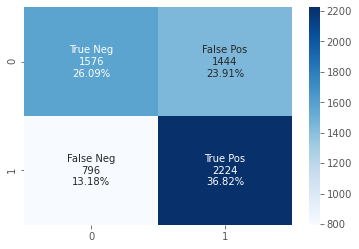

In [41]:
# Konfusionsmatrix
cf_matrix_bt = confusion_matrix(y_test[['response']], y_pred_nn)

group_names_bt = ['True Neg','False Pos','False Neg','True Pos']

group_counts_bt = ["{0:0.0f}".format(value) for value in
                cf_matrix_bt.flatten()]

group_percentages_bt = ["{0:.2%}".format(value) for value in cf_matrix_bt.flatten()/np.sum(cf_matrix_bt)]


labels_bt = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_bt,group_counts_bt,group_percentages_bt)]

labels_bt = np.asarray(labels_bt).reshape(2,2)

sns.heatmap(cf_matrix_bt, annot=labels_bt, fmt='', cmap='Blues')

#### Feature Importance
Hat noch nicht funktioniert

#### ROC-Curve

In [42]:
fpr, tpr, _ = roc_curve(y_test['response'], y_pred_nn_proba)
auc_score_nn = roc_auc_score(y_test['response'], y_pred_nn_proba)


fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC-Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)


fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)


fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

# Evaluation der Modell auf dem neuen Testdatensatz

In [43]:
test_data_df = pd.read_csv('./data/test.csv', sep='[,$]' , decimal=".", engine='python')

test_data_df.columns = test_data_df.columns.str.lower()

test_data_df.rename(columns={
    'id': 'id',
    'gender': 'gender',
    'age': 'age',
    'driving_license': 'driving_license',
    'region_code': 'region_code',
    'previously_insured': 'previously_insured',
    'vehicle_age': 'vehicle_age',
    'vehicle__damage': 'vehicle_damage',
    'annual__premium': 'annual_premium',
    'policy_sales_channel': 'policy_sales_channel',
    'vintage': 'vintage'
},
    inplace=True)


index_max_age = test_data_df[test_data_df["age"] >= 100].index
test_data_df.drop(index_max_age, inplace=True)

index_min_age = test_data_df[test_data_df["age"] < 18].index
test_data_df.drop(index_min_age, inplace=True)

index_min_premium = test_data_df[test_data_df["annual_premium"] <= 0].index
test_data_df.drop(index_min_premium, inplace=True)

index_max_premium = test_data_df[test_data_df["annual_premium"] >= 150000].index
test_data_df.drop(index_max_premium, inplace=True)

def map_categorials(df):

    vehicle_age_map = {
        '< 1 Year': 0,
        '1-2 Year': 1,
        '> 2 Years': 2
    }

    vehicle_damage_map = {
        'No': 0,
        'Yes': 1
    }

    df.loc[:,'vehicle_age'] = df['vehicle_age'].map(vehicle_age_map).astype('Int64')
    df.loc[:,'vehicle_damage'] = df['vehicle_damage'].map(vehicle_damage_map)

    LE = LabelEncoder()
    df['region_code'] = LE.fit_transform(df.loc[:,'region_code'])
    df['gender'] = LE.fit_transform(df.loc[:, 'gender'])

    return df

test_data_df_label_encoded = map_categorials(test_data_df)

## Random Forest Classifier Test Set